## Les méthodes d’apprentissage étudiées dans ces TP sont les suivantes : SVM, RandomForest, AdaBoost et GradientBoosting

### Partie 1 :

In [1]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import numpy as np
import warnings

# Pour ignorer les FutureWarnings inutiles
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

In [68]:
# Paths
labels_ca_path = os.path.join(os.getcwd(), "acsincome_ca_labels.csv")
features_ca_path = os.path.join(os.getcwd(), "acsincome_ca_features.csv")

features_ca_without_sex_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_features_without_sex.csv")
features_ca_without_race_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_features_without_race.csv")

group_sex_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_group_Sex.csv")
group_race_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_group_Race.csv")


labels_ne_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ne_labelTP2.csv")
features_ne_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ne_allfeaturesTP2.csv")

labels_co_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_co_labelTP2.csv")
features_co_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_co_allfeaturesTP2.csv")

In [69]:
preprocessor = ColumnTransformer(transformers=[
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'), [1, 2, 3, 4, 5, 6, 8, 9]),
                                        ('standardize', StandardScaler(), [0, 7])
                                    ])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [70]:
def get_data(labels_path, features_path, size=0.05):
    features = pd.read_csv(features_path)
    labels = pd.read_csv(labels_path)

    X_all, y_all = shuffle(features, labels, random_state=3)
    # only use the first N samples to limit training time
    num_samples = int(len(X_all) * size)
    X, y = X_all[:num_samples], y_all[:num_samples]
    
    y = np.array(y).reshape(-1)

    return np.array(X), y

In [71]:
X, y = get_data(labels_ca_path, features_ca_path, 0.05)
X_processed = pipeline.fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

#### (1) Mettre en place une validation croisée

In [7]:
models = {"SVM": LinearSVC(), "Random Forest": RandomForestClassifier(), "Ada Boost": AdaBoostClassifier(), "Gradient Boosting": GradientBoostingClassifier()}
for name, model in models.items():
    print(f"{name} : Cross_val_score = {cross_val_score(model, X_test, y_test, scoring='accuracy', cv=5)}")

SVM : Cross_val_score = [0.78571429 0.73214286 0.75959079 0.77237852 0.79028133]
Random Forest : Cross_val_score = [0.80357143 0.74744898 0.78005115 0.79028133 0.80306905]
Ada Boost : Cross_val_score = [0.81122449 0.7244898  0.76470588 0.76214834 0.78005115]
Gradient Boosting : Cross_val_score = [0.82908163 0.7372449  0.77237852 0.78005115 0.78772379]


#### (2) Qualité des modèles d’apprentissages en utilisant différentes métriques (accuracy, confusion_matrix)

In [72]:
# Evaluation de la qualité du modèle avec différentes métriques (accuracy, classification_report, confusion_matrix)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} : \n accuracy_score = {np.round(accuracy_score(y_test, y_pred), 3)}")
    #print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


SVM : 
 accuracy_score = 0.813
[[970 184]
 [182 621]]

Random Forest : 
 accuracy_score = 0.808
[[971 183]
 [193 610]]

Ada Boost : 
 accuracy_score = 0.797
[[956 198]
 [199 604]]

Gradient Boosting : 
 accuracy_score = 0.804
[[955 199]
 [185 618]]


#### (3) Mettre en place une recherche des bons hyperparamètres (gridsearchCV)

In [73]:
# Recherche des bons hyperparamètres avec GridSearch
def get_model_and_grid_SVM():
    model = LinearSVC()
    param_grid = {
        'C': [0.01, 0.05, 0.1],
        'tol': [1e-2, 1e-3],
        'loss': ['squared_hinge', 'hinge'],
    }
    # Best score = 0.809
    #  Best params = {'C': 0.05, 'loss': 'squared_hinge', 'tol': 0.01}
    return model, param_grid


def get_model_and_grid_RandomFOrest():
    model = RandomForestClassifier()
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ["gini", "entropy", "log_loss"],
        'max_features': ["sqrt", "log2", None]
    }
    # Best score = 0.81
    # Best params = {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200}
    return model, param_grid


def get_model_and_grid_AdaBoost():
    model = AdaBoostClassifier()
    param_grid = {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.75, 1, 1.25]
    }
    # Best score = 0.81
    # Best params = {'learning_rate': 1, 'n_estimators': 100}
    return model, param_grid


def get_model_and_grid_GradientBoosting():
    model = GradientBoostingClassifier()
    param_grid = {
        'loss': ["log_loss", "exponential"],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'criterion': ["friedman_mse", "squared_error"]
    }
    # Best score = 0.81
    # Best params = {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'log_loss' 'n_estimators': 300}
    return model, param_grid

In [75]:
find_best_param = True
if find_best_param:
    models_and_grids = [get_model_and_grid_SVM(),
                        get_model_and_grid_RandomFOrest(),
                        get_model_and_grid_AdaBoost(),
                        get_model_and_grid_GradientBoosting()]
    for model_and_grid in models_and_grids:
        model, param_grid = model_and_grid
        grid = GridSearchCV(model, param_grid, cv=5)
        grid.fit(X_train, y_train)
        print(f"Best score = {np.round(grid.best_score_, 3)}\n Best params = {grid.best_params_}")
        model = grid.best_estimator_
        print(np.round(model.score(X_test, y_test), 3))

Best score = 0.809
 Best params = {'C': 0.05, 'loss': 'squared_hinge', 'tol': 0.01}
0.816


KeyboardInterrupt: 

In [9]:
X_ca_raw, y_ca = get_data(labels_ca_path, features_ca_path, 0.05)
X_co_raw, y_co = get_data(labels_co_path, features_co_path, 1)
X_ne_raw, y_ne = get_data(labels_ne_path, features_ne_path, 1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(np.concatenate((X_ca_raw, X_co_raw, X_ne_raw), axis=0))

X_ca = pipeline.transform(X_ca_raw)
X_co = pipeline.transform(X_co_raw)
X_ne = pipeline.transform(X_ne_raw)

X_train, X_test, y_train, y_test = train_test_split(X_ca, y_ca, test_size=0.2, random_state=5)


models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=200),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

for name, model in models.items():
    print(f"\n### {name} ###")
    model.fit(X_train, y_train)

    print(f"\n# Colorado #\n")
    y_pred_co = model.predict(X_co)
    print(f"Accuracy_score = {np.round(accuracy_score(y_co, y_pred_co), 3)}")
    # print(classification_report(y_co, y_pred_co))
    print(confusion_matrix(y_co, y_pred_co))

    print(f"\n# Nevada #\n")
    y_pred_ne = model.predict(X_ne)
    print(f"Accuracy_score = {np.round(accuracy_score(y_ne, y_pred_ne), 3)}")
    # print(classification_report(y_ne, y_pred_ne))
    print(confusion_matrix(y_ne, y_pred_ne))


### SVM ###

# Colorado #

Accuracy_score = 0.76
[[12748  5586]
 [ 1927 11045]]

# Nevada #

Accuracy_score = 0.767
[[5848 1569]
 [ 947 2421]]

### Random Forest ###

# Colorado #

Accuracy_score = 0.771
[[13423  4911]
 [ 2266 10706]]

# Nevada #

Accuracy_score = 0.755
[[5473 1944]
 [ 702 2666]]

### Ada Boost ###

# Colorado #

Accuracy_score = 0.739
[[11920  6414]
 [ 1759 11213]]

# Nevada #

Accuracy_score = 0.755
[[6310 1107]
 [1534 1834]]

### Gradient Boosting ###

# Colorado #

Accuracy_score = 0.759
[[12721  5613]
 [ 1933 11039]]

# Nevada #

Accuracy_score = 0.744
[[5374 2043]
 [ 720 2648]]


## Partie 2

### 1/ Explicabilité des modèles

In [122]:
def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix between features', fontsize=15)
    plt.show()

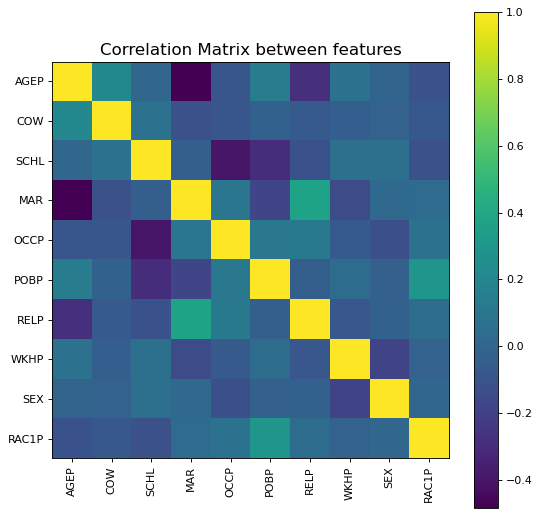

In [123]:
plotCorrelationMatrix(pd.read_csv(features_ca_path), 8)

#### a) Corrélation entre features et label pour les données d'entraînements

Pour les données d'entraîenement : [0.266, 0.054, 0.35, -0.266, -0.341, -0.086, -0.228, 0.338, -0.118, -0.101]


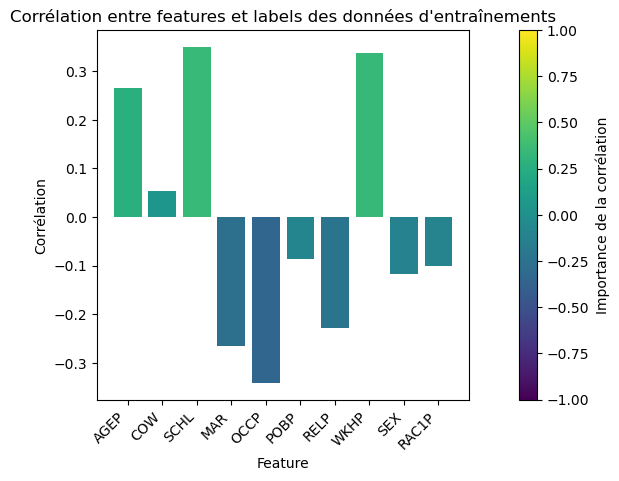

In [86]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

correlations_train = []

X_ca_raw, y_ca = get_data(labels_ca_path, features_ca_path, 1)

features_name = ["AGEP", "COW", "SCHL", "MAR", "OCCP", "POBP", "RELP", "WKHP", "SEX", "RAC1P"]

for i in range(X_ca_raw.shape[1]):
    corr, _ = pearsonr(np.array(X_ca_raw)[:, i], y_ca)
    correlations_train.append(np.round(corr, 3))

print(f"Pour les données d'entraîenement : {correlations_train}")

norm = mcolors.Normalize(vmin=-1, vmax=1)
colors = plt.cm.viridis(norm(correlations_train))

plt.bar(features_name, correlations_train, color=colors)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.1)
cbar.set_label('Importance de la corrélation')
plt.xticks(rotation= 45, ha="right")
plt.ylabel('Corrélation')
plt.xlabel('Feature')
plt.title("Corrélation entre features et labels des données d'entraînements")

plt.show()

#### b) Corrélation entre chaque feature et le label prédit pour les différents modèles

SVM : [0.303, 0.056, 0.447, -0.295, -0.442, -0.125, -0.267, 0.406, -0.115, -0.113]


/tmp/ipykernel_54641/109715358.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(features_name, rotation=45, ha="right")


Random Forest : [0.279, 0.078, 0.448, -0.323, -0.404, -0.119, -0.287, 0.36, -0.129, -0.133]
Ada Boost : [0.312, 0.07, 0.431, -0.311, -0.392, -0.126, -0.286, 0.405, -0.116, -0.146]
Gradient Boosting : [0.306, 0.06, 0.437, -0.31, -0.379, -0.129, -0.293, 0.426, -0.117, -0.128]


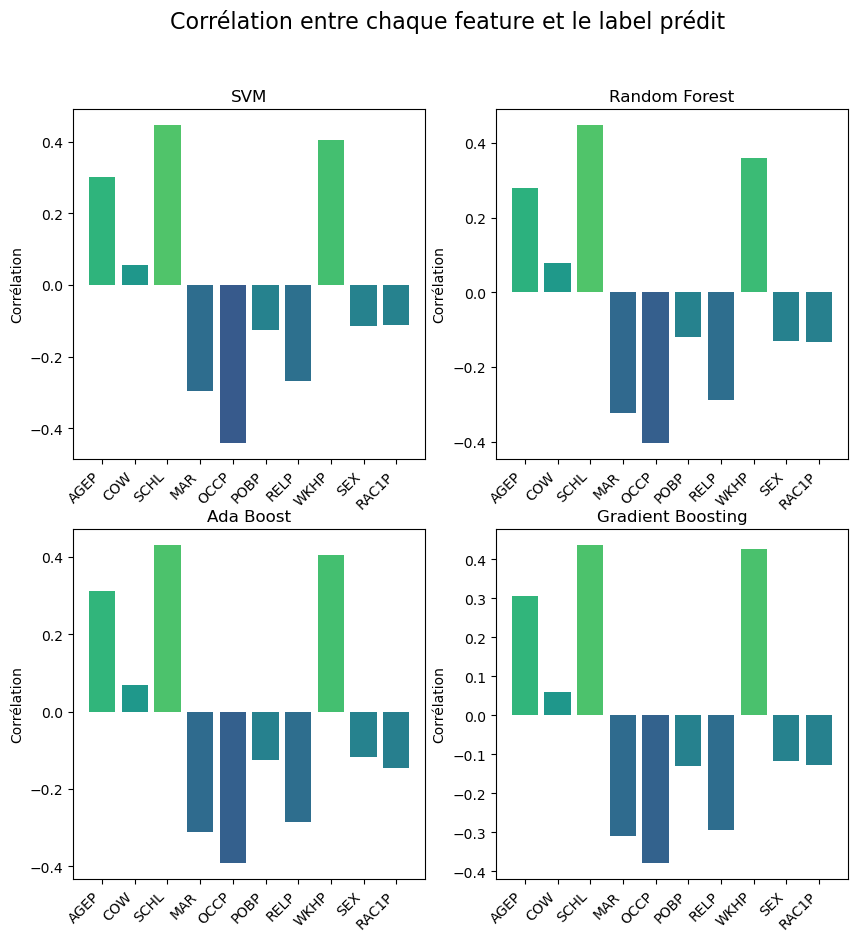

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Corrélation entre chaque feature et le label prédit', fontsize=16)

_, X_test_raw, _, y_test = train_test_split(X_ca_raw, y_ca, test_size=0.2, random_state=5)

X_test = pipeline.transform(X_test_raw)

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    correlations_pred = []
    for i in range(X_test_raw.shape[1]):
        corr, _ = pearsonr(np.array(X_test_raw)[:, i], y_pred)
        correlations_pred.append(np.round(corr, 3))
    
    print(f"{name} : {correlations_pred}")
    
    row, col = divmod(idx, 2)

    ax = axes[row, col]

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    colors = plt.cm.viridis(norm(correlations_pred))
    ax.set_xticks(np.arange(len(features_name)))

    ax.bar(features_name, correlations_pred, color=colors)
    ax.set_xticklabels(features_name, rotation=45, ha="right")
    ax.set_ylabel('Corrélation')
    ax.set_title(f"{name}")

plt.show()

#### c) Feature importance 

In [98]:
X, y = get_data(labels_ca_path, features_ca_path, 0.05)
X_processed = StandardScaler().fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=100),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

SVM : [0.02639918 0.00163557 0.06854076 0.00342448 0.03465372 0.00500894
 0.01081012 0.06690519 0.00950677 0.00061334]
Random Forest : [0.14395604 0.03887043 0.14303603 0.04065934 0.1756964  0.06723741
 0.08602096 0.17086634 0.04980833 0.02473805]
Ada Boost : [0.03815487 0.00291337 0.04865832 0.0010989  0.04541273 0.00582673
 0.02001022 0.06818298 0.00268336 0.        ]
Gradient Boosting : [0.06222847 0.01275236 0.05479172 0.0026067  0.08801431 0.01433683
 0.02059801 0.08729875 0.00697674 0.00442116]


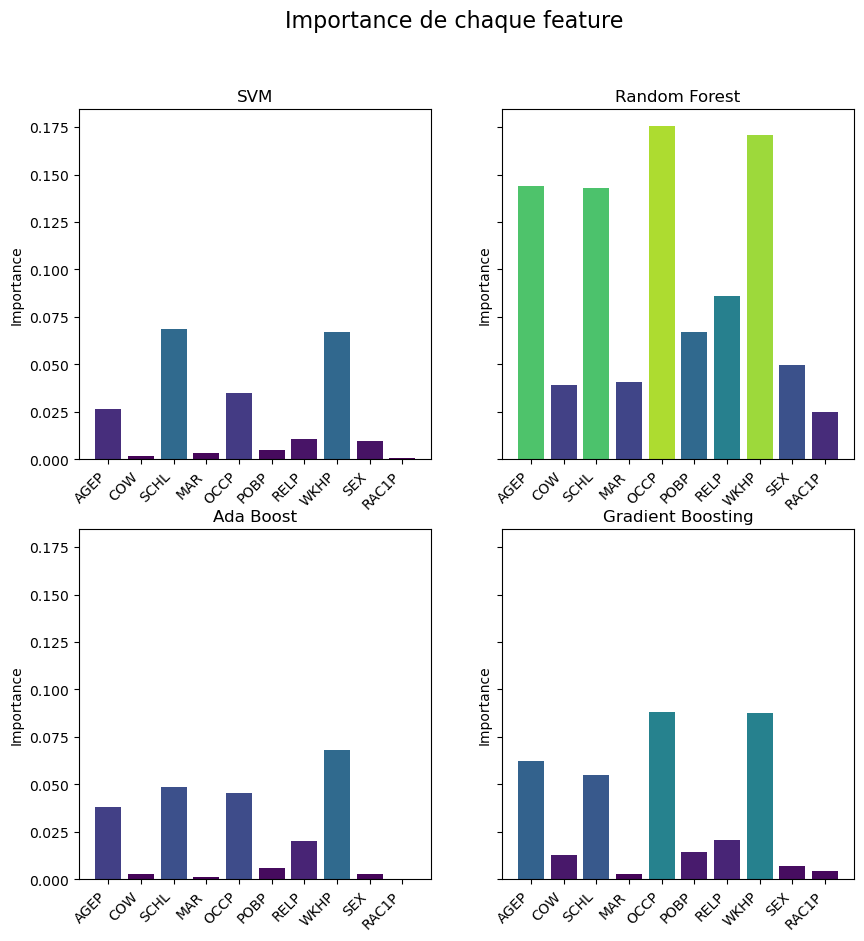

In [101]:
from sklearn.inspection import permutation_importance

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
fig.suptitle('Importance de chaque feature', fontsize=16)

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    res = permutation_importance(model, X_train, y_train)
    
    print(f"{name} : {res['importances_mean']}")
    
    row, col = divmod(idx, 2)

    ax = axes[row, col]

    norm = mcolors.Normalize(vmin=0, vmax=0.2)
    colors = plt.cm.viridis(norm(res['importances_mean']))

    ax.bar(features_name, res['importances_mean'], color=colors)
    ax.set_xticks(np.arange(len(features_name)))
    ax.set_xticklabels(features_name, rotation=45, ha="right")

    ax.set_ylabel('Importance')
    ax.set_title(f"{name}")

plt.show()

### 2/ Equité des modèles

#### i) Feature SEX

In [15]:
X, y = get_data(labels_ca_path, features_ca_path, 1)
X_processed = StandardScaler().fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=100),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

for model in models.values():
    model.fit(X_train, y_train)

#### a) Confusion matrix, statistical parity et equal opportunity pour chaque valeur de l'attribut SEX et pour chaque modèle

In [16]:
group_sex = np.array(pd.read_csv(group_sex_path))

X_male_train = [X_train[i] for i in range(X_train.shape[0]) if group_sex[i] == 1]
y_male_train = [y_train[i] for i in range(len(y_train)) if group_sex[i] == 1]
X_female_train = [X_train[i] for i in range(X_train.shape[0]) if group_sex[i] == 2]
y_female_train = [y_train[i] for i in range(len(y_train)) if group_sex[i] == 2]
X_male_test = [X_test[i] for i in range(X_test.shape[0]) if group_sex[i] == 1]
y_male_test = [y_test[i] for i in range(len(y_test)) if group_sex[i] == 1]
X_female_test = [X_test[i] for i in range(X_test.shape[0]) if group_sex[i] == 2]
y_female_test = [y_test[i] for i in range(len(y_test)) if group_sex[i] == 2]

In [17]:
def print_equity_stats(y_male_pred, y_male, y_female_pred, y_female):
    # Confusion matrix
    conf_matrix_male = np.array(confusion_matrix(y_male, y_male_pred))
    conf_matrix_female = np.array(confusion_matrix(y_female, y_female_pred))
    print(f"Confusion Matrix : \n male = \n{conf_matrix_male}\n female = \n{conf_matrix_female}")
    # Statistical Parity: comparer les taux de prédictions positives
    stat_parity_male = np.round(np.sum(conf_matrix_male[:, 0]) / np.sum(conf_matrix_male), 3)
    stat_parity_female = np.round(np.sum(conf_matrix_female[:, 0]) / np.sum(conf_matrix_female), 3)

    print(f"Statistical Parity : \nFor male : {stat_parity_male}\nFor female : {stat_parity_female}\n"
          f"Ratio (male/female) : {np.round(stat_parity_male / stat_parity_female, 3)}")

    # Equal Opportunity : comparer les taux de vrais positifs
    equal_opportunity_male = np.round(conf_matrix_male[0, 0] / sum(conf_matrix_male[0]), 3)
    equal_opportunity_female = np.round(conf_matrix_female[0, 0] / sum(conf_matrix_female[0]), 3)

    print(f"Equal Opportunity : \nFor male : {equal_opportunity_male}\nFor female : {equal_opportunity_female}\n"
          f"Ratio (male/female) : {np.round(equal_opportunity_male / equal_opportunity_female, 3)}")

    # Predictive Equality : comparer les taux de faux positifs
    predictive_equality_male = np.round(conf_matrix_male[1, 0] / sum(conf_matrix_male[1]), 3)
    predictive_equality_female = np.round(conf_matrix_female[1, 0] / sum(conf_matrix_female[1]), 3)

    print(f"Predictive Equality : \nFor male : {predictive_equality_male}\nFor female : {predictive_equality_female}\n"
          f"Ratio (male/female) : {np.round(predictive_equality_male / predictive_equality_female, 3)}")

In [18]:
for name, model in models.items():
    print(f"\n{name} : \n")
    # TRAIN
    print("\nTRAIN SET\n")
    y_male_pred_train = model.predict(X_male_train)
    y_female_pred_train = model.predict(X_female_train)
    print_equity_stats(y_male_pred_train, y_male_train, y_female_pred_train, y_female_train)

    # TEST
    print("\nTEST SET\n")
    y_male_pred_test = model.predict(X_male_test)
    y_female_pred_test = model.predict(X_female_test)
    print_equity_stats(y_male_pred_test, y_male_test, y_female_pred_test, y_female_test)


SVM : 


TRAIN SET

Confusion Matrix : 
 male = 
[[40504  8248]
 [ 9517 24493]]
 female = 
[[35853  7493]
 [ 8550 21874]]
Statistical Parity : 
For male : 0.604
For female : 0.602
Ratio (male/female) : 1.003
Equal Opportunity : 
For male : 0.831
For female : 0.827
Ratio (male/female) : 1.005
Predictive Equality : 
For male : 0.28
For female : 0.281
Ratio (male/female) : 0.996

TEST SET

Confusion Matrix : 
 male = 
[[10302  2158]
 [ 2437  6115]]
 female = 
[[8946 1826]
 [2013 5336]]
Statistical Parity : 
For male : 0.606
For female : 0.605
Ratio (male/female) : 1.002
Equal Opportunity : 
For male : 0.827
For female : 0.83
Ratio (male/female) : 0.996
Predictive Equality : 
For male : 0.285
For female : 0.274
Ratio (male/female) : 1.04

Random Forest : 


TRAIN SET

Confusion Matrix : 
 male = 
[[48653    99]
 [   99 33911]]
 female = 
[[43265    81]
 [   71 30353]]
Statistical Parity : 
For male : 0.589
For female : 0.587
Ratio (male/female) : 1.003
Equal Opportunity : 
For male : 0.99

#### b) Confusion matrix, statistical parity et equal opportunity pour chaque modèle avec le dataset sans la feature SEX

In [81]:
models = {"SVM": LinearSVC(max_iter=10000, C=0.5, fit_intercept=True, loss="hinge", tol=0.001),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=200),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss",
                                                          max_depth=3, n_estimators=100)}

X, y = get_data(labels_ca_path, features_ca_without_sex_path, 1)
X_processed = StandardScaler().fit_transform(X)


# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

X_male_train = [X_train[i] for i in range(len(X_train)) if group_sex[i] == 1]
y_male_train = [y_train[i] for i in range(len(y_train)) if group_sex[i] == 1]
X_female_train = [X_train[i] for i in range(len(X_train)) if group_sex[i] == 2]
y_female_train = [y_train[i] for i in range(len(y_train)) if group_sex[i] == 2]
X_male_test = [X_test[i] for i in range(len(X_test)) if group_sex[i] == 1]
y_male_test = [y_test[i] for i in range(len(y_test)) if group_sex[i] == 1]
X_female_test = [X_test[i] for i in range(len(X_test)) if group_sex[i] == 2]
y_female_test = [y_test[i] for i in range(len(y_test)) if group_sex[i] == 2]

In [83]:
for name, model in models.items():
    print(f"\n#{name} : \n")
    model.fit(X_train, y_train)

    # TRAIN
    print("TRAIN SET")
    y_male_pred_train = model.predict(X_male_train)
    y_female_pred_train = model.predict(X_female_train)
    print_equity_stats(y_male_pred_train, y_male_train, y_female_pred_train, y_female_train)

    # TEST
    print("\nTEST SET")
    y_male_pred_test = model.predict(X_male_test)
    y_female_pred_test = model.predict(X_female_test)
    print_equity_stats(y_male_pred_test, y_male_test, y_female_pred_test, y_female_test)


#SVM : 

TRAIN SET
Confusion Matrix : 
 male = 
[[39908  8844]
 [ 9085 24925]]
 female = 
[[35383  7963]
 [ 8231 22193]]
Statistical Parity : 
For male : 0.592
For female : 0.591
Ratio (male/female) : 1.002
Equal Opportunity : 
For male : 0.819
For female : 0.816
Ratio (male/female) : 1.004
Predictive Equality : 
For male : 0.267
For female : 0.271
Ratio (male/female) : 0.985

TEST SET
Confusion Matrix : 
 male = 
[[10145  2315]
 [ 2319  6233]]
 female = 
[[8822 1950]
 [1924 5425]]
Statistical Parity : 
For male : 0.593
For female : 0.593
Ratio (male/female) : 1.0
Equal Opportunity : 
For male : 0.814
For female : 0.819
Ratio (male/female) : 0.994
Predictive Equality : 
For male : 0.271
For female : 0.262
Ratio (male/female) : 1.034

#Random Forest : 

TRAIN SET
Confusion Matrix : 
 male = 
[[48607   145]
 [  125 33885]]
 female = 
[[43232   114]
 [   83 30341]]
Statistical Parity : 
For male : 0.589
For female : 0.587
Ratio (male/female) : 1.003
Equal Opportunity : 
For male : 0.997


#### i) Feature RAC1P

In [19]:
X, y = get_data(labels_ca_path, features_ca_path, 1)
X_processed = StandardScaler().fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=100),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

for model in models.values():
    model.fit(X_train, y_train)

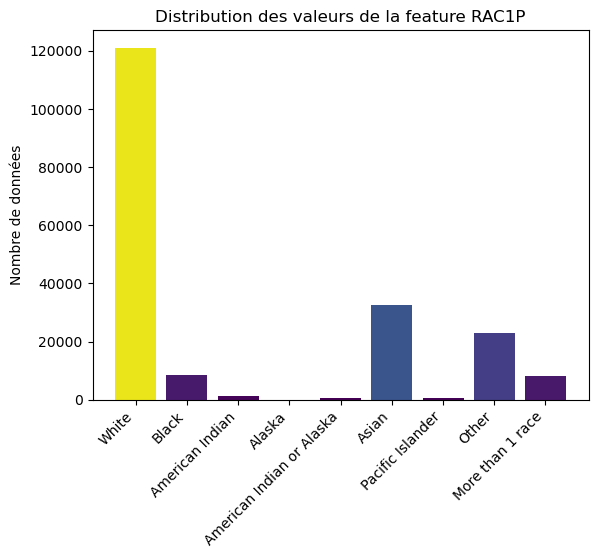

{1: 121006, 2: 8557, 3: 1294, 4: 13, 5: 450, 6: 32709, 7: 637, 8: 22793, 9: 8206}


In [58]:
from collections import Counter

group_race = np.array(pd.read_csv(group_race_path)).reshape(-1)

name_possible_race = ["White", "Black", "American Indian", "Alaska", "American Indian or Alaska",
                      "Asian", "Pacific Islander", "Other", "More than 1 race"]

repartition = dict(sorted(dict(Counter(list(group_race))).items()))

norm = mcolors.Normalize(vmin=0, vmax=125000)
colors = plt.cm.viridis(norm(list(repartition.values())))

plt.bar(name_possible_race, repartition.values(), color=colors)

plt.xticks(rotation= 45, ha="right")

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)

plt.ylabel('Nombre de données')
plt.title("Distribution des valeurs de la feature RAC1P")

plt.show()

print(repartition)

#### a)  Confusion matrix, statistical parity et equal opportunity pour chaque valeur de l'attribut RAC1P et pour chaque modèle

In [59]:
X_white_train = [X_train[i] for i in range(X_train.shape[0]) if group_race[i] == 1]
y_white_train = [y_train[i] for i in range(len(y_train)) if group_race[i] == 1]
X_others_train = [X_train[i] for i in range(X_train.shape[0]) if group_race[i] != 1]
y_others_train = [y_train[i] for i in range(len(y_train)) if group_race[i] != 1]
X_white_test = [X_test[i] for i in range(X_test.shape[0]) if group_race[i] == 1]
y_white_test = [y_test[i] for i in range(len(y_test)) if group_race[i] == 1]
X_others_test = [X_test[i] for i in range(X_test.shape[0]) if group_race[i] != 1]
y_others_test = [y_test[i] for i in range(len(y_test)) if group_race[i] != 1]

In [62]:
def print_equity_stats_RAC1P(y_white_pred, y_white, y_others_pred, y_others):
    # Confusion matrix
    conf_matrix_white = np.array(confusion_matrix(y_white, y_white_pred))
    conf_matrix_others = np.array(confusion_matrix(y_others, y_others_pred))
    print(f"Confusion Matrix : \n white = \n{conf_matrix_white}\n others = \n{conf_matrix_others}")
    
    # Statistical Parity: compare positive prediction rates
    stat_parity_white = np.round(np.sum(conf_matrix_white[:, 0]) / np.sum(conf_matrix_white), 3)
    stat_parity_others = np.round(np.sum(conf_matrix_others[:, 0]) / np.sum(conf_matrix_others), 3)

    print(f"Statistical Parity : \nFor white : {stat_parity_white}\nFor others : {stat_parity_others}\n"
          f"Ratio (white/others) : {np.round(stat_parity_white / stat_parity_others, 3)}")

    # Equal Opportunity: compare true positive rates
    equal_opportunity_white = np.round(conf_matrix_white[0, 0] / sum(conf_matrix_white[0]), 3)
    equal_opportunity_others = np.round(conf_matrix_others[0, 0] / sum(conf_matrix_others[0]), 3)

    print(f"Equal Opportunity : \nFor white : {equal_opportunity_white}\nFor others : {equal_opportunity_others}\n"
          f"Ratio (white/others) : {np.round(equal_opportunity_white / equal_opportunity_others, 3)}")

    # Predictive Equality: compare false positive rates
    predictive_equality_white = np.round(conf_matrix_white[1, 0] / sum(conf_matrix_white[1]), 3)
    predictive_equality_others = np.round(conf_matrix_others[1, 0] / sum(conf_matrix_others[1]), 3)

    print(f"Predictive Equality : \nFor white : {predictive_equality_white}\nFor others : {predictive_equality_others}\n"
          f"Ratio (white/others) : {np.round(predictive_equality_white / predictive_equality_others, 3)}")


In [63]:
for name, model in models.items():
    print(f"\n{name} : \n")
    # TRAIN
    print("\nTRAIN SET\n")
    y_white_pred_train = model.predict(X_white_train)
    y_others_pred_train = model.predict(X_others_train)
    print_equity_stats_RAC1P(y_white_pred_train, y_white_train, y_others_pred_train, y_others_train)

    # TEST
    print("\nTEST SET\n")
    y_white_pred_test = model.predict(X_white_test)
    y_others_pred_test = model.predict(X_others_test)
    print_equity_stats_RAC1P(y_white_pred_test, y_white_test, y_others_pred_test, y_others_test)


SVM : 


TRAIN SET

Confusion Matrix : 
 white = 
[[47223  9758]
 [11309 28553]]
 others = 
[[29134  5983]
 [ 6757 17815]]
Statistical Parity : 
For white : 0.604
For others : 0.601
Ratio (white/others) : 1.005
Equal Opportunity : 
For white : 0.829
For others : 0.83
Ratio (white/others) : 0.999
Predictive Equality : 
For white : 0.284
For others : 0.275
Ratio (white/others) : 1.033

TEST SET

Confusion Matrix : 
 white = 
[[11817  2422]
 [ 2696  6989]]
 others = 
[[7431 1562]
 [1754 4462]]
Statistical Parity : 
For white : 0.607
For others : 0.604
Ratio (white/others) : 1.005
Equal Opportunity : 
For white : 0.83
For others : 0.826
Ratio (white/others) : 1.005
Predictive Equality : 
For white : 0.278
For others : 0.282
Ratio (white/others) : 0.986

Random Forest : 


TRAIN SET

Confusion Matrix : 
 white = 
[[56878   103]
 [  111 39751]]
 others = 
[[35036    81]
 [   56 24516]]
Statistical Parity : 
For white : 0.588
For others : 0.588
Ratio (white/others) : 1.0
Equal Opportunity : 

#### b) Confusion matrix, statistical parity et equal opportunity pour chaque modèle avec le dataset sans la feature RAC1P

In [66]:
models = {"SVM": LinearSVC(max_iter=10000, C=0.5, fit_intercept=True, loss="hinge", tol=0.001),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=200),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss",
                                                          max_depth=3, n_estimators=100)}

X, y = get_data(labels_ca_path, features_ca_without_race_path, 1)
X_processed = StandardScaler().fit_transform(X)


# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

X_white_train = [X_train[i] for i in range(X_train.shape[0]) if group_race[i] == 1]
y_white_train = [y_train[i] for i in range(len(y_train)) if group_race[i] == 1]
X_others_train = [X_train[i] for i in range(X_train.shape[0]) if group_race[i] != 1]
y_others_train = [y_train[i] for i in range(len(y_train)) if group_race[i] != 1]
X_white_test = [X_test[i] for i in range(X_test.shape[0]) if group_race[i] == 1]
y_white_test = [y_test[i] for i in range(len(y_test)) if group_race[i] == 1]
X_others_test = [X_test[i] for i in range(X_test.shape[0]) if group_race[i] != 1]
y_others_test = [y_test[i] for i in range(len(y_test)) if group_race[i] != 1]

In [67]:
for name, model in models.items():
    print(f"\n#{name} : \n")
    model.fit(X_train, y_train)

    # TRAIN
    print("TRAIN SET")
    y_white_pred_train = model.predict(X_white_train)
    y_others_pred_train = model.predict(X_others_train)
    print_equity_stats(y_white_pred_train, y_white_train, y_others_pred_train, y_others_train)

    # TEST
    print("\nTEST SET")
    y_white_pred_test = model.predict(X_white_test)
    y_others_pred_test = model.predict(X_others_test)
    print_equity_stats(y_white_pred_test, y_white_test, y_others_pred_test, y_others_test)



#SVM : 

TRAIN SET
Confusion Matrix : 
 white = 
[[47031  9950]
 [10973 28889]]
 others = 
[[29000  6117]
 [ 6588 17984]]
Statistical Parity : 
For white : 0.599
For others : 0.596
Ratio (white/others) : 1.005
Equal Opportunity : 
For white : 0.825
For others : 0.826
Ratio (white/others) : 0.999
Predictive Equality : 
For white : 0.275
For others : 0.268
Ratio (white/others) : 1.026

TEST SET
Confusion Matrix : 
 white = 
[[11763  2476]
 [ 2619  7066]]
 others = 
[[7394 1599]
 [1691 4525]]
Statistical Parity : 
For white : 0.601
For others : 0.597
Ratio (white/others) : 1.007
Equal Opportunity : 
For white : 0.826
For others : 0.822
Ratio (white/others) : 1.005
Predictive Equality : 
For white : 0.27
For others : 0.272
Ratio (white/others) : 0.993

#Random Forest : 

TRAIN SET
Confusion Matrix : 
 white = 
[[56811   170]
 [  208 39654]]
 others = 
[[34994   123]
 [  100 24472]]
Statistical Parity : 
For white : 0.589
For others : 0.588
Ratio (white/others) : 1.002
Equal Opportunity : 